* Importing the neccessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from lr_utils import load_dataset


# Loading Image Classification Data







In [2]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
print('Shape before flattening: ',train_set_x_orig.shape, train_set_y.shape, test_set_x_orig.shape, test_set_y.shape)

flattened_train = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
flattened_test = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

Shape before flattening:  (209, 64, 64, 3) (1, 209) (50, 64, 64, 3) (1, 50)


* Scaling the images between 0 and 1

In [3]:
X_train = flattened_train / 255
X_test = flattened_test / 255
y_train = train_set_y
y_test = test_set_y

print('Shape after flattening: ',X_train.shape, X_test.shape, y_test.shape)

Shape after flattening:  (12288, 209) (12288, 50) (1, 50)


# Writing Functions for a Neural Network

* initialize parameters

In [4]:
def initialize_param(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters['W'+str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * (2/ np.sqrt(layer_dims[l-1]))
        parameters['b'+str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

* forward propagation for a single layer

In [5]:
def S_forward_propagation(A_prev , W, b, activation):
    Z = np.dot(W, A_prev) + b
    if activation == 'relu':
        A = np.maximum(0,Z)
    elif activation == 'sigmoid':
        A = 1 / (1+np.exp(-Z))
    
    cache = (A_prev, Z, W, b)
    return A, cache

* forward propagation for a L layer neural network

In [6]:
def L_forward_propagation(A_prev , parameters):
    L = len(parameters) // 2
    caches = []
    for l in range(1, L):
        W, b = parameters['W'+str(l)], parameters['b'+str(l)]
        A, cache = S_forward_propagation(A_prev, W, b, activation='relu')
        caches.append(cache)
        A_prev = A
    
    W, b = parameters['W'+str(L)], parameters['b'+str(L)]
    AL, cache = S_forward_propagation(A_prev, W, b, activation='sigmoid')
    caches.append(cache)
    return AL, caches

* computing regularized cost

In [7]:
def compute_regularized_cost(AL, y , lambd, parameters):
    m = y.shape[1]
    cost = (1/m) * -(np.dot(y, np.log(AL).T) + np.dot(1-y, np.log(1-AL).T)) 
    
    L = len(parameters) // 2
    
    reg = 0
    for l in range(1, L+1):
        reg = reg + np.sum(np.square(parameters['W'+str(l)]))
    
    reg_cost = cost + (lambd/(2*m)) * reg
    
    return np.squeeze(reg_cost)

* computing gradients for all the parameters

In [8]:
def compute_grads(AL, y , caches, lambd):
    dZL = AL - y
    L = len(caches)
    grads = {}
    m = y.shape[1]
    
    A_prev = caches[L-1][0]
    W = caches[L-1][2]
#     b = caches[L-1][3]
    grads['dW'+str(L)] = 1/m * np.dot(dZL, A_prev.T) + ((lambd/m) * W)
    grads['db'+str(L)] = 1/m * np.sum(dZL, axis=1, keepdims=True)
    
    dZ = dZL
    for l in range(L-1, 0,-1):
        A, A_prev = caches[l][0] , caches[l-1][0]
        Wahead , W = caches[l][2] , caches[l-1][2]        
        
        dA = np.dot(Wahead.T, dZ)
        dZ = np.multiply(dA, np.int64(A > 0))
        grads['dW'+str(l)] = 1/m * np.dot(dZ, A_prev.T) + ((lambd/m) * W)
        grads['db'+str(l)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
        
    return grads   

* updating the parameters

In [9]:
def update_parameters(parameters, grads, alpha):
    L = len(parameters) // 2
    
    updated_params = {}
    
    for l in range(1, L+1):
        updated_params['W'+str(l)] =parameters['W'+str(l)] - alpha * grads['dW'+str(l)] 
        updated_params['b'+str(l)] =parameters['b'+str(l)] - alpha * grads['db'+str(l)]         
        
    return updated_params

* Evaluating the model

In [10]:
def predict(weights, X):
    AL,_ = L_forward_propagation(X, weights)
    return np.int64(AL >= 0.5)

In [11]:
def accuracy(y, ypred):
    return np.mean(y == ypred)*100

* Making batches of shape (nx , n) from the entire dataset where n is the size of the batch.

In [12]:
def mini_batch(X,y, size,seed):
    import math
    np.random.seed(seed)
    m = X.shape[1]
    num = math.floor(m/size)
    permutation = list(np.random.permutation(m))
    Xshuffled = X[:,permutation]
    yshuffled = y[:,permutation]    
    
    batches = []
    for i in range(num):
        minibatchX = Xshuffled[:, i*size : (i+1)*size]
        minibatchy = yshuffled[:, i*size : (i+1)*size]        
        minibatch = minibatchX, minibatchy
        batches.append(minibatch)
        
    rem = m%size
    if rem != 0: 
        minibatchX = Xshuffled[:, -rem:]
        minibatchy = yshuffled[:, -rem:]   
        minibatch = minibatchX, minibatchy
        batches.append(minibatch)
    
    return batches

# Adam Optimizer

* Initializing v and s, both v and s will have a shape similar to that of the parameters. v and s will be initialized to zero.

In [13]:
def initialize_adam(params):
    v = {}
    s = {}
    L = len(params)//2
    for l in range(1, L+1):
        v['dW'+str(l)] = np.zeros(params['W'+str(l)].shape)
        v['db'+str(l)] = np.zeros(params['b'+str(l)].shape)        

        s['dW'+str(l)] = np.zeros(params['W'+str(l)].shape)
        s['db'+str(l)] = np.zeros(params['b'+str(l)].shape)        

    return v,s

* Updating parameters using v and s. v_corr and s_corr is basically computed for bias correction.
* E == epsilon to make sure we are not dividing v_corr by 0 in the parameter update step
* t = iteration number

In [14]:
def update_params_with_adam(params, grads, v,s, t, beta1,beta2,E,learning_rate):
    
    L = len(params) // 2
    v_corr = {}
    s_corr = {}
 
    
    for l in range(1,L+1):
        v['dW'+str(l)] = v['dW'+str(l)] * beta1 + (1-beta1) * grads['dW'+str(l)]
        v['db'+str(l)] = v['db'+str(l)] * beta1 + (1-beta1) * grads['db'+str(l)]
        
        v_corr['dW'+str(l)] = v['dW'+str(l)] / (1-beta1**t)
        v_corr['db'+str(l)] = v['db'+str(l)] / (1-beta1**t)

        s['dW'+str(l)] = s['dW'+str(l)] * beta2 + (1-beta2) * grads['dW'+str(l)]**2
        s['db'+str(l)] = s['db'+str(l)] * beta2 + (1-beta2) * grads['db'+str(l)]**2
        
        s_corr['dW'+str(l)] = s['dW'+str(l)] / (1-beta2**t)
        s_corr['db'+str(l)] = s['db'+str(l)] / (1-beta2**t)
        
        params['W'+str(l)] = params['W'+str(l)] - learning_rate * (v_corr['dW'+str(l)] / (np.sqrt(s_corr['dW'+str(l)]) +E) ) 
        params['b'+str(l)] = params['b'+str(l)] - learning_rate * (v_corr['db'+str(l)] / (np.sqrt(s_corr['db'+str(l)]) +E) ) 
        
        
    return params, v, s

* Building a complex neural network model using Adam.

In [15]:
def model_adam(X, y, nodes, alpha, epoch, size=64, beta1=0.9, beta2=0.999, E = 1e-8, lambd=0, print_cost=True):
    
    seed = 10
    parameters = initialize_param(nodes)
    L = len(parameters)//2
    m = y.shape[1]
    t = 0

    cost = []
    for i in range(epoch+1):
        v,s = initialize_adam(parameters)
        seed += 1
        # randomly shuffling the X and Y before creating batches at every epoch
        minibatches = mini_batch(X,y,size,seed)
        cost_total = 0
        
        for minibatch in minibatches:
            (minibatchX, minibatchy) = minibatch
            AL, caches = L_forward_propagation(minibatchX, parameters)
            cost_total += compute_regularized_cost(AL, minibatchy, lambd, parameters)
            grad = compute_grads(AL, minibatchy, caches,lambd)
            t+=1
            parameters,v,s = update_params_with_adam(parameters,grad,v,s,t,beta1,beta2,E,alpha)
        
        cost_avg = cost_total/m
        
        if print_cost==True and i % 100 == 0:
            cost.append(cost_avg)
            print ("Cost after epoch {}: {}" .format(i, cost_avg))
            
    return cost, parameters       

* Evaluating our model on the image classification data.

In [16]:
nodes = [12288,7,1]

cost1_A,weights1_A = model_adam(X_train, y_train, nodes, 0.00001,1000,lambd=0.2)

Cost after epoch 0: 0.014578887655420583
Cost after epoch 100: 0.01049877686512822
Cost after epoch 200: 0.007958520484061917
Cost after epoch 300: 0.006046414815802909
Cost after epoch 400: 0.004854303876526592
Cost after epoch 500: 0.003808204557752234
Cost after epoch 600: 0.0033193301803363753
Cost after epoch 700: 0.0026465888098181236
Cost after epoch 800: 0.002375950145260364
Cost after epoch 900: 0.00224864301857638
Cost after epoch 1000: 0.002043959158707329


Accuracy achieved by Adam Optimization on the image classification data: 80%


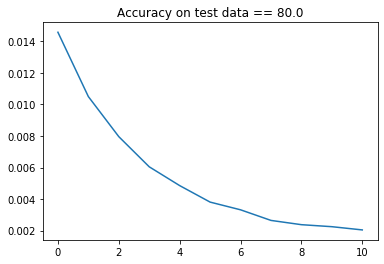

In [17]:
ypred = predict(weights1_A, X_test)
accuracy_ = accuracy(y_test, ypred)
plt.plot(cost1_A)
plt.title('Accuracy on test data == {}'.format(accuracy_))
print('Accuracy achieved by Adam Optimization on the image classification data: {}%'.format(np.int64(accuracy_)))

# Saving weights

In [52]:
np.save('weights.npy',weights1_A)